In [ ]:
import torch 
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import Dataset,DataLoader
import matplotlib.pylab as plt
import numpy as np
import os
import glob
from PIL import Image

#**Downloading data**


In [ ]:
!mkdir resources
!mkdir resources/data
!wget -O resources/data/concrete_crack_images_for_classification.zip "https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/concrete_crack_images_for_classification.zip"


--2023-03-20 04:45:39--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/concrete_crack_images_for_classification.zip
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 245259777 (234M) [application/zip]
Saving to: ‘resources/data/concrete_crack_images_for_classification.zip’

resources/data/conc 100%[===================>] 233.90M  30.6MB/s    in 7.8s    

2023-03-20 04:45:47 (29.9 MB/s) - ‘resources/data/concrete_crack_images_for_classification.zip’ saved [245259777/245259777]



In [ ]:
from zipfile import ZipFile
with ZipFile("/content/resources/data/concrete_crack_images_for_classification.zip", 'r') as zObject:
                zObject.extractall(path="/content/resources/data")

**Creating Dataset class** 

In [ ]:
class Dataset(Dataset):

    # Constructor
    def __init__(self,transform,train):
        directory="resources/data"
        positive="Positive"
        negative="Negative"

        positive_file_path=os.path.join(directory,positive)
        negative_file_path=os.path.join(directory,negative)
        positive_files=[os.path.join(positive_file_path,file) for file in  os.listdir(positive_file_path) if file.endswith(".jpg")]
        positive_files.sort()
        negative_files=[os.path.join(negative_file_path,file) for file in  os.listdir(negative_file_path) if file.endswith(".jpg")]
        negative_files.sort()
        number_of_samples = len(positive_files)+len(negative_files)

        self.all_files=[None]*number_of_samples
        self.all_files[::2]=positive_files
        self.all_files[1::2]=negative_files 
        # The transform is goint to be used on image
        self.transform = transform
        #torch.LongTensor
        self.Y=torch.zeros([number_of_samples]).type(torch.LongTensor)
        self.Y[::2]=1
        self.Y[1::2]=0
        
        if train:
            self.all_files=self.all_files[0:3000]
            self.Y=self.Y[0:3000]
            self.len=len(self.all_files)
        else:
            self.all_files=self.all_files[3000:]
            self.Y=self.Y[3000:]
            self.len=len(self.all_files)
    
  
            
     
       
    # Get the length
    def __len__(self):
        return self.len
    
    # Getter
    def __getitem__(self, idx):
        
        
        image=Image.open(self.all_files[idx])
        y=self.Y[idx]
          
        
        # If there is any transform method, apply it onto the image
        if self.transform:
            image = self.transform(image)

        return image, y

In [ ]:
model = models.resnet18(pretrained = True)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
mean = [0.485,0.456,0.406]
std = [0.229,0.224,0.225]
composed  = transforms.Compose([transforms.Resize(224),transforms.ToTensor(),transforms.Normalize(mean,std)])

In [ ]:
train_dataset = Dataset(transform = composed,train = True)
val_dataset = Dataset(transform = composed,train = False)


In [ ]:
for param in model.parameters():
  param.requires_grad = False
model.fc = nn.Linear(512,2)  
train_loader = torch.utils.data.DataLoader(dataset = train_dataset,batch_size=15)
val_loader = torch.utils.data.DataLoader(dataset = val_dataset,batch_size =10)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam([parameters for parameters in model.parameters() if parameters.requires_grad],lr = 0.03)

In [ ]:
n_epochs = 3
loss_list =  []
accuracy_list =[]
correct =0
n_test = len(val_dataset)


In [ ]:
for epoch in range(n_epochs):
  loss_sublist = []
  for x,y in train_loader:
    model.train()
    optimizer.zero_grad()
    z = model(x)
    loss = criterion(z,y)
    loss_sublist.append(loss.data.item())
    loss.backward()
    optimizer.step()
  loss_list.append(np.mean(loss_sublist)) 
  correct =0
  for x_test,y_test in val_loader:
    model.eval()
    z = model(x_test)
    _,yhat = torch.max(z.data,1)
    correct+=(yhat==y_test).sum().item()
    accuracy = correct/n_test
    accuracy_list.append(accuracy)


In [ ]:
max(accuracy_list)

0.987

Text(0, 0.5, 'total_loss')

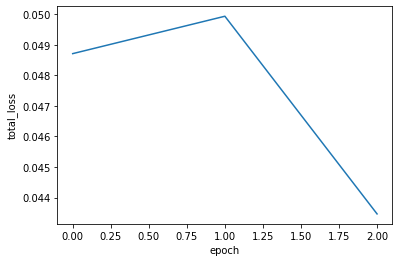

In [ ]:
plt.plot(loss_list)
plt.xlabel('epoch')
plt.ylabel('total_loss')

In [ ]:
def show_data(data_sample):
    plt.imshow(Image.open(data_sample))
    #plt.title('y = ' + str(data_sample[1]))

In [ ]:
val_loader1 = torch.utils.data.DataLoader(dataset = val_dataset,batch_size =1)
val_dset = Dataset(transform = None,train = False)

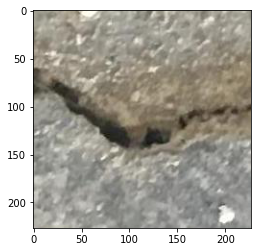

sample 38 predicted value: tensor([0]) actual value:tensor([1])


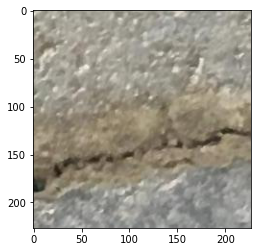

sample 40 predicted value: tensor([0]) actual value:tensor([1])


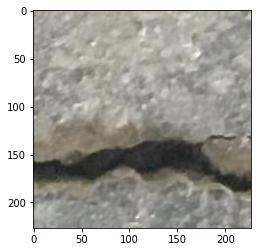

sample 46 predicted value: tensor([0]) actual value:tensor([1])


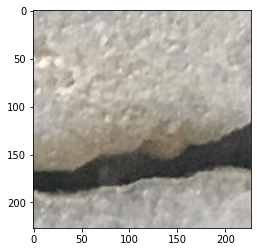

sample 58 predicted value: tensor([0]) actual value:tensor([1])


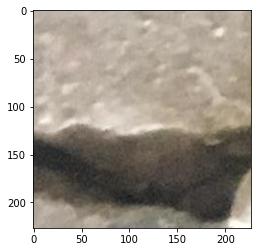

sample 74 predicted value: tensor([0]) actual value:tensor([1])


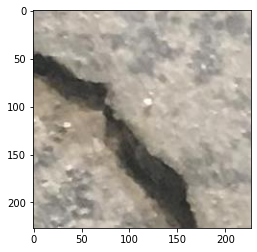

sample 80 predicted value: tensor([0]) actual value:tensor([1])


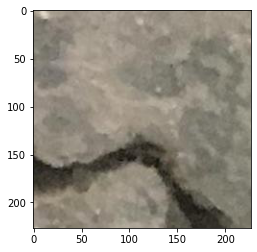

sample 134 predicted value: tensor([0]) actual value:tensor([1])


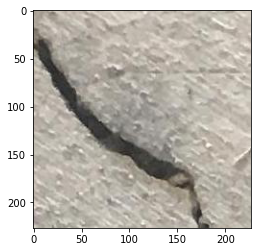

sample 162 predicted value: tensor([0]) actual value:tensor([1])


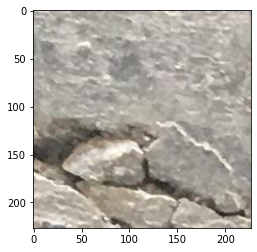

sample 228 predicted value: tensor([0]) actual value:tensor([1])


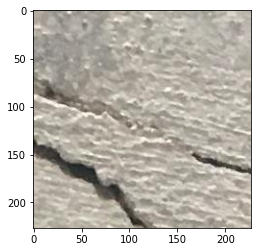

sample 232 predicted value: tensor([0]) actual value:tensor([1])


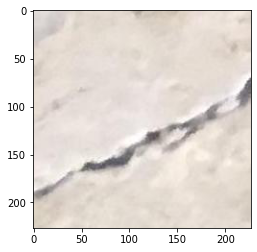

sample 286 predicted value: tensor([0]) actual value:tensor([1])


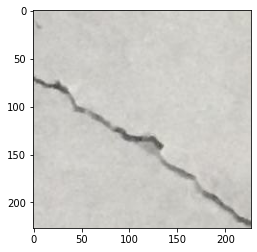

sample 462 predicted value: tensor([0]) actual value:tensor([1])


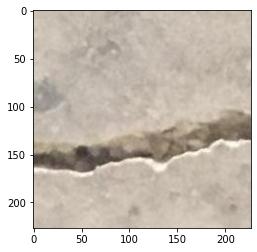

sample 740 predicted value: tensor([0]) actual value:tensor([1])


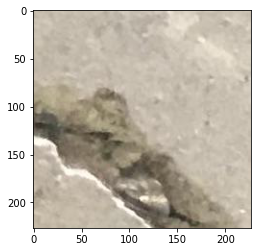

sample 850 predicted value: tensor([0]) actual value:tensor([1])


In [ ]:
for count,(x_test,y_test) in enumerate(val_loader1):
    model.eval()
    count1 =0
    z = model(x_test)
    x_test = x_test[-1,:,:,:]
    _,yhat = torch.max(z.data,1)
    if yhat != y_test:
        plt.imshow(val_dset[count][0])
        plt.show()
        print("sample {} predicted value: {} actual value:{}".format(count,yhat,y_test))
        count1 += 1
    if count1 >= 5:
        break       